In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from common import *

set_random_seed(RANDOM_STATE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import tensorflow as tf

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# 1. Load dataset

In [46]:
data              = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Preprocessing

## 1) Feature engineering

In [49]:
%%time

MARKER      = -9999
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 144
SHUFFLE     = False
TEST_SIZE   = 0

# 1. Generate time
data_with_time = generate_full_timestamp(data)

# 2. Imputing
data_imp = impute_data(data_with_time)

# 3. Feature engineering
data_fe = feature_engineering(data_imp)

# 4. Smoothing
data_sm = smooth(data_fe, 'Patv')

# 5. Feature selection (select features)
cols = select_features(data_sm, threshold=0.2)  # cols[-1]: Patv

# 6. Split dataset
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(data_sm, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)

# 7. Mark anomaly
idxs_mark = [get_idxs_mark(d) for d in train_y]

# 8. Feature selection (apply)
train_x = [d[cols] for d in train_x]
train_y = [d[cols] for d in train_y]
test_x  = [d[cols] for d in test_x]

# 9. Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_sm[cols].values)

train_x_norm = scale(train_x, scaler)
train_y_norm = scale(train_y, scaler)
test_x_norm  = scale(test_x, scaler)

# 10. Positional encoding
P = positional_encoding(train_x_norm.shape[1], d=train_x_norm.shape[-1])[None, :]

# 11. Final data
train_x_fin = train_x_norm + P
train_y_fin = train_y_norm + P
test_x_fin  = test_x_norm  + P

# 12. Mark data
train_y_mark_fin = copy(train_y_fin)
for i, idx in enumerate(idxs_mark):
    train_y_mark_fin[i][idx, -1] = MARKER

print("* Final data")
print("  - Train data(X, y):", np.shape(train_x_fin), np.shape(train_y_fin), np.shape(train_y_mark_fin))
print("  - Test data(X)    :", np.shape(test_x_fin))

* Final data
  - Train data(X, y): (25553, 288, 20) (25553, 288, 20) (25553, 288, 20)
  - Test data(X)    : (134, 288, 20)


## 2) Select small dataset

In [50]:
BATCH_SIZE = 32
train_ds = generate_dataset(train_x_fin, train_y_fin, batch_size=BATCH_SIZE, shuffle=True)
test_ds  = generate_dataset(test_x_fin, batch_size=1)

# 3. Modeling

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(input_shape[-1])(x)
    return keras.Model(inputs, outputs)

In [30]:
from tensorflow.keras.metrics import RootMeanSquaredError
from evaluation.metrics import CondLoss

input_shape = np.shape(train_x)[1:]
model = build_model(input_shape,
                    head_size=256, num_heads=8, ff_dim=8, num_transformer_blocks=8, mlp_units=[128],
                    mlp_dropout=0.4, dropout=0.4)
model.compile(optimizer='adam', loss=CondLoss('rmse', MARKER), metrics=[RootMeanSquaredError(), 'mae'])

In [31]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 288, 20)]    0           []                               
                                                                                                  
 layer_normalization_136 (Layer  (None, 288, 20)     40          ['input_6[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_68 (Multi  (None, 288, 20)     170004      ['layer_normalization_136[0][0]',
 HeadAttention)                                                   'layer_normalization_136[0][0]']
                                                                                            

 HeadAttention)                                                   'layer_normalization_142[0][0]']
                                                                                                  
 dropout_147 (Dropout)          (None, 288, 20)      0           ['multi_head_attention_71[0][0]']
                                                                                                  
 tf.__operators__.add_142 (TFOp  (None, 288, 20)     0           ['dropout_147[0][0]',            
 Lambda)                                                          'tf.__operators__.add_141[0][0]'
                                                                 ]                                
                                                                                                  
 layer_normalization_143 (Layer  (None, 288, 20)     40          ['tf.__operators__.add_142[0][0]'
 Normalization)                                                  ]                                
          

 layer_normalization_149 (Layer  (None, 288, 20)     40          ['tf.__operators__.add_148[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 conv1d_148 (Conv1D)            (None, 288, 8)       168         ['layer_normalization_149[0][0]']
                                                                                                  
 dropout_154 (Dropout)          (None, 288, 8)       0           ['conv1d_148[0][0]']             
                                                                                                  
 conv1d_149 (Conv1D)            (None, 288, 20)      180         ['dropout_154[0][0]']            
                                                                                                  
 tf.__operators__.add_149 (TFOp  (None, 288, 20)     0           ['conv1d_149[0][0]',             
 Lambda)  

# 4. Training

# 5. Check results

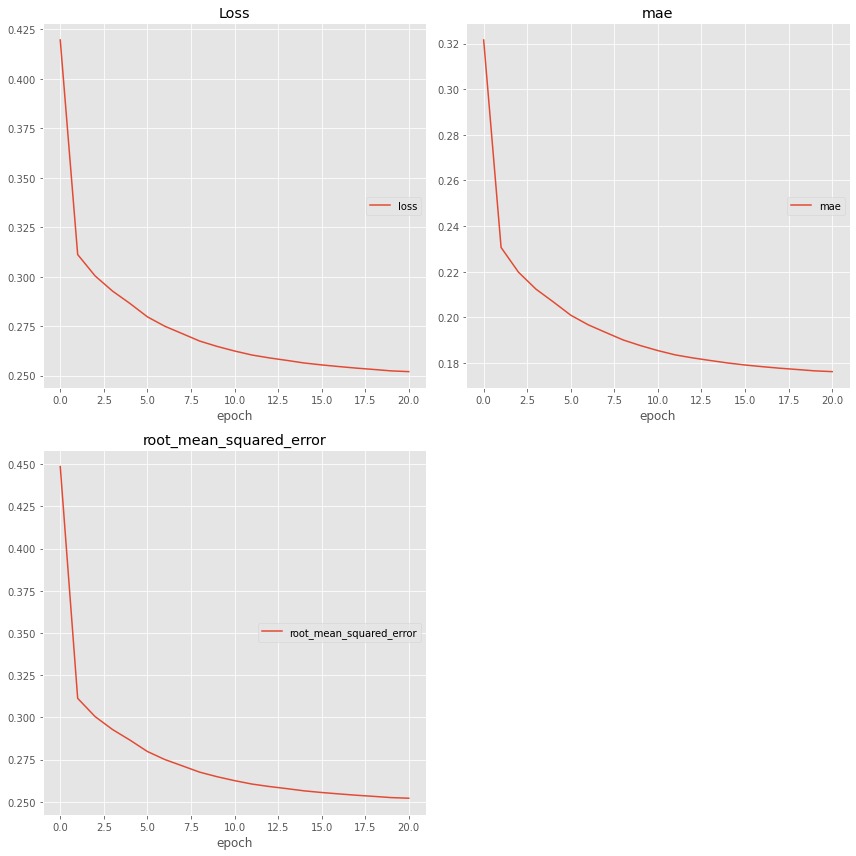

Loss
	loss             	 (min:    0.252, max:    0.420, cur:    0.252)
mae
	mae              	 (min:    0.176, max:    0.322, cur:    0.176)
root_mean_squared_error
	root_mean_squared_error 	 (min:    0.252, max:    0.449, cur:    0.252)
799/799 [==============================] - 80s 100ms/step - loss: 0.2521 - root_mean_squared_error: 0.2521 - mae: 0.1763
Epoch 22/50
434/799 [===============>..............] - ETA: 36s - loss: 0.2510 - root_mean_squared_error: 0.2510 - mae: 0.1759

KeyboardInterrupt: 

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

plt.style.use('ggplot')
model.fit(train_ds, epochs=50,
#           validation_data=val_ds,
          callbacks=[
              PlotLossesKeras(),
#               EarlyStopping(patience=10, restore_best_weights=True),
#               ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
          ]);

## 1) Training set

In [41]:
X      = train_x_fin
y_true = train_y_fin - P
y_pred = model.predict(X) - P

799/799 [==============================] - 29s 36ms/step


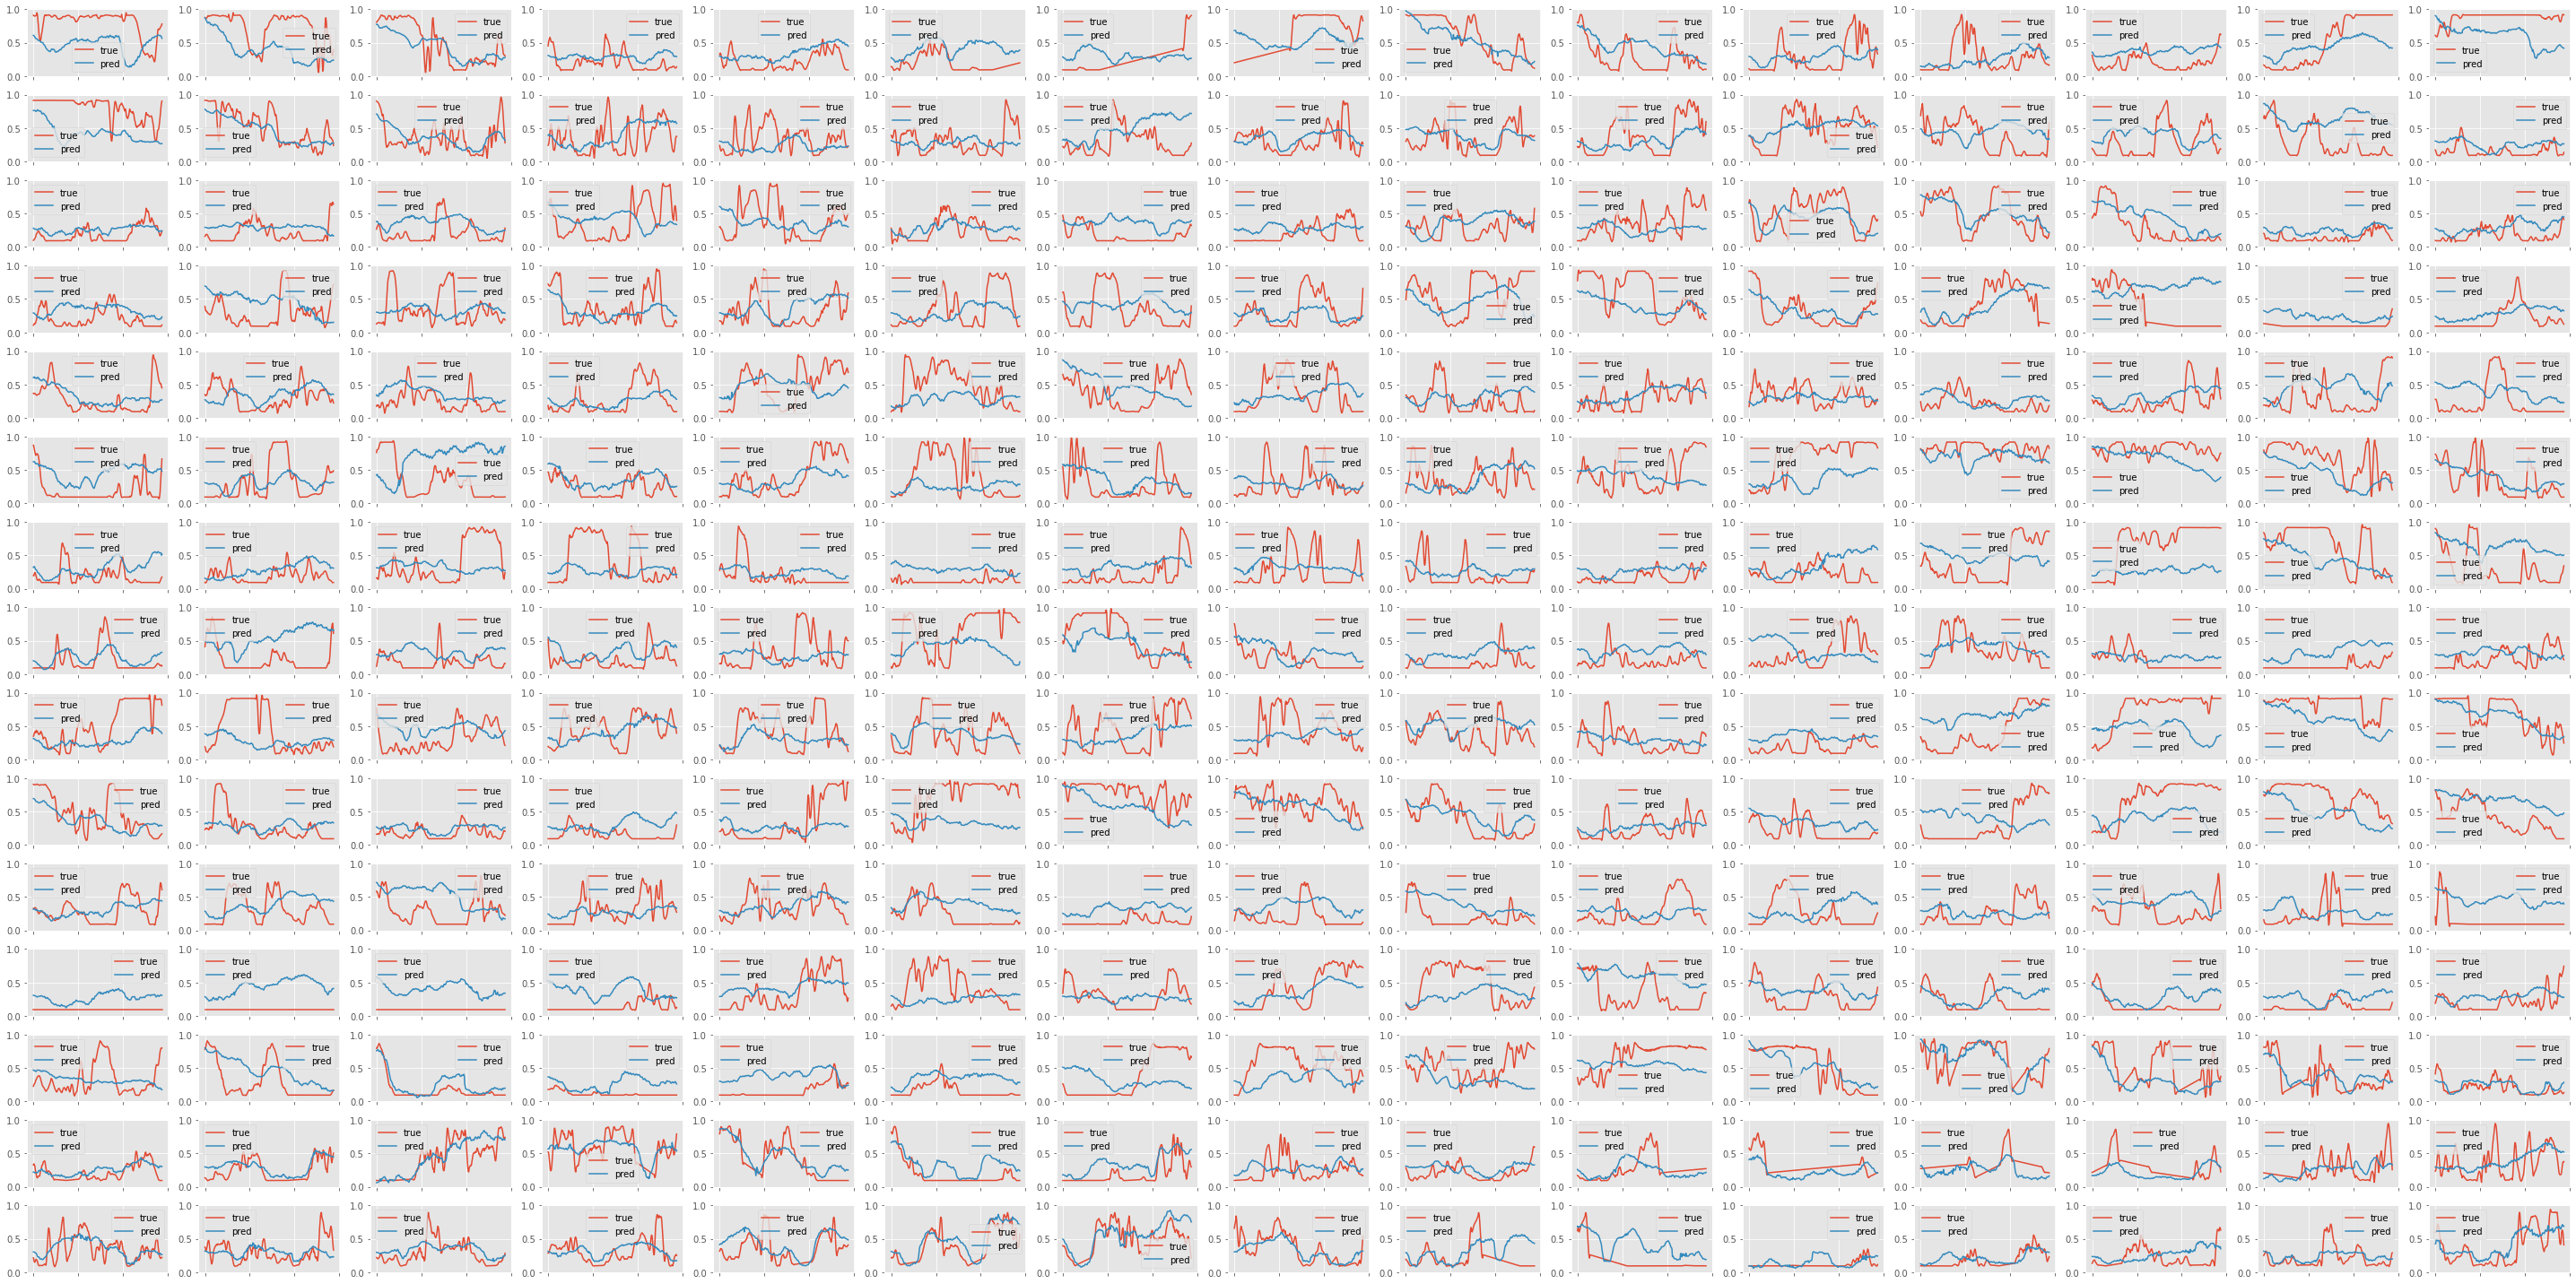

In [42]:
y_true_norm = y_true[:, :, -1]
y_pred_norm = y_pred[:, :, -1]
visualize_result(y_true_norm, y_pred_norm, ylim=[0, 1])

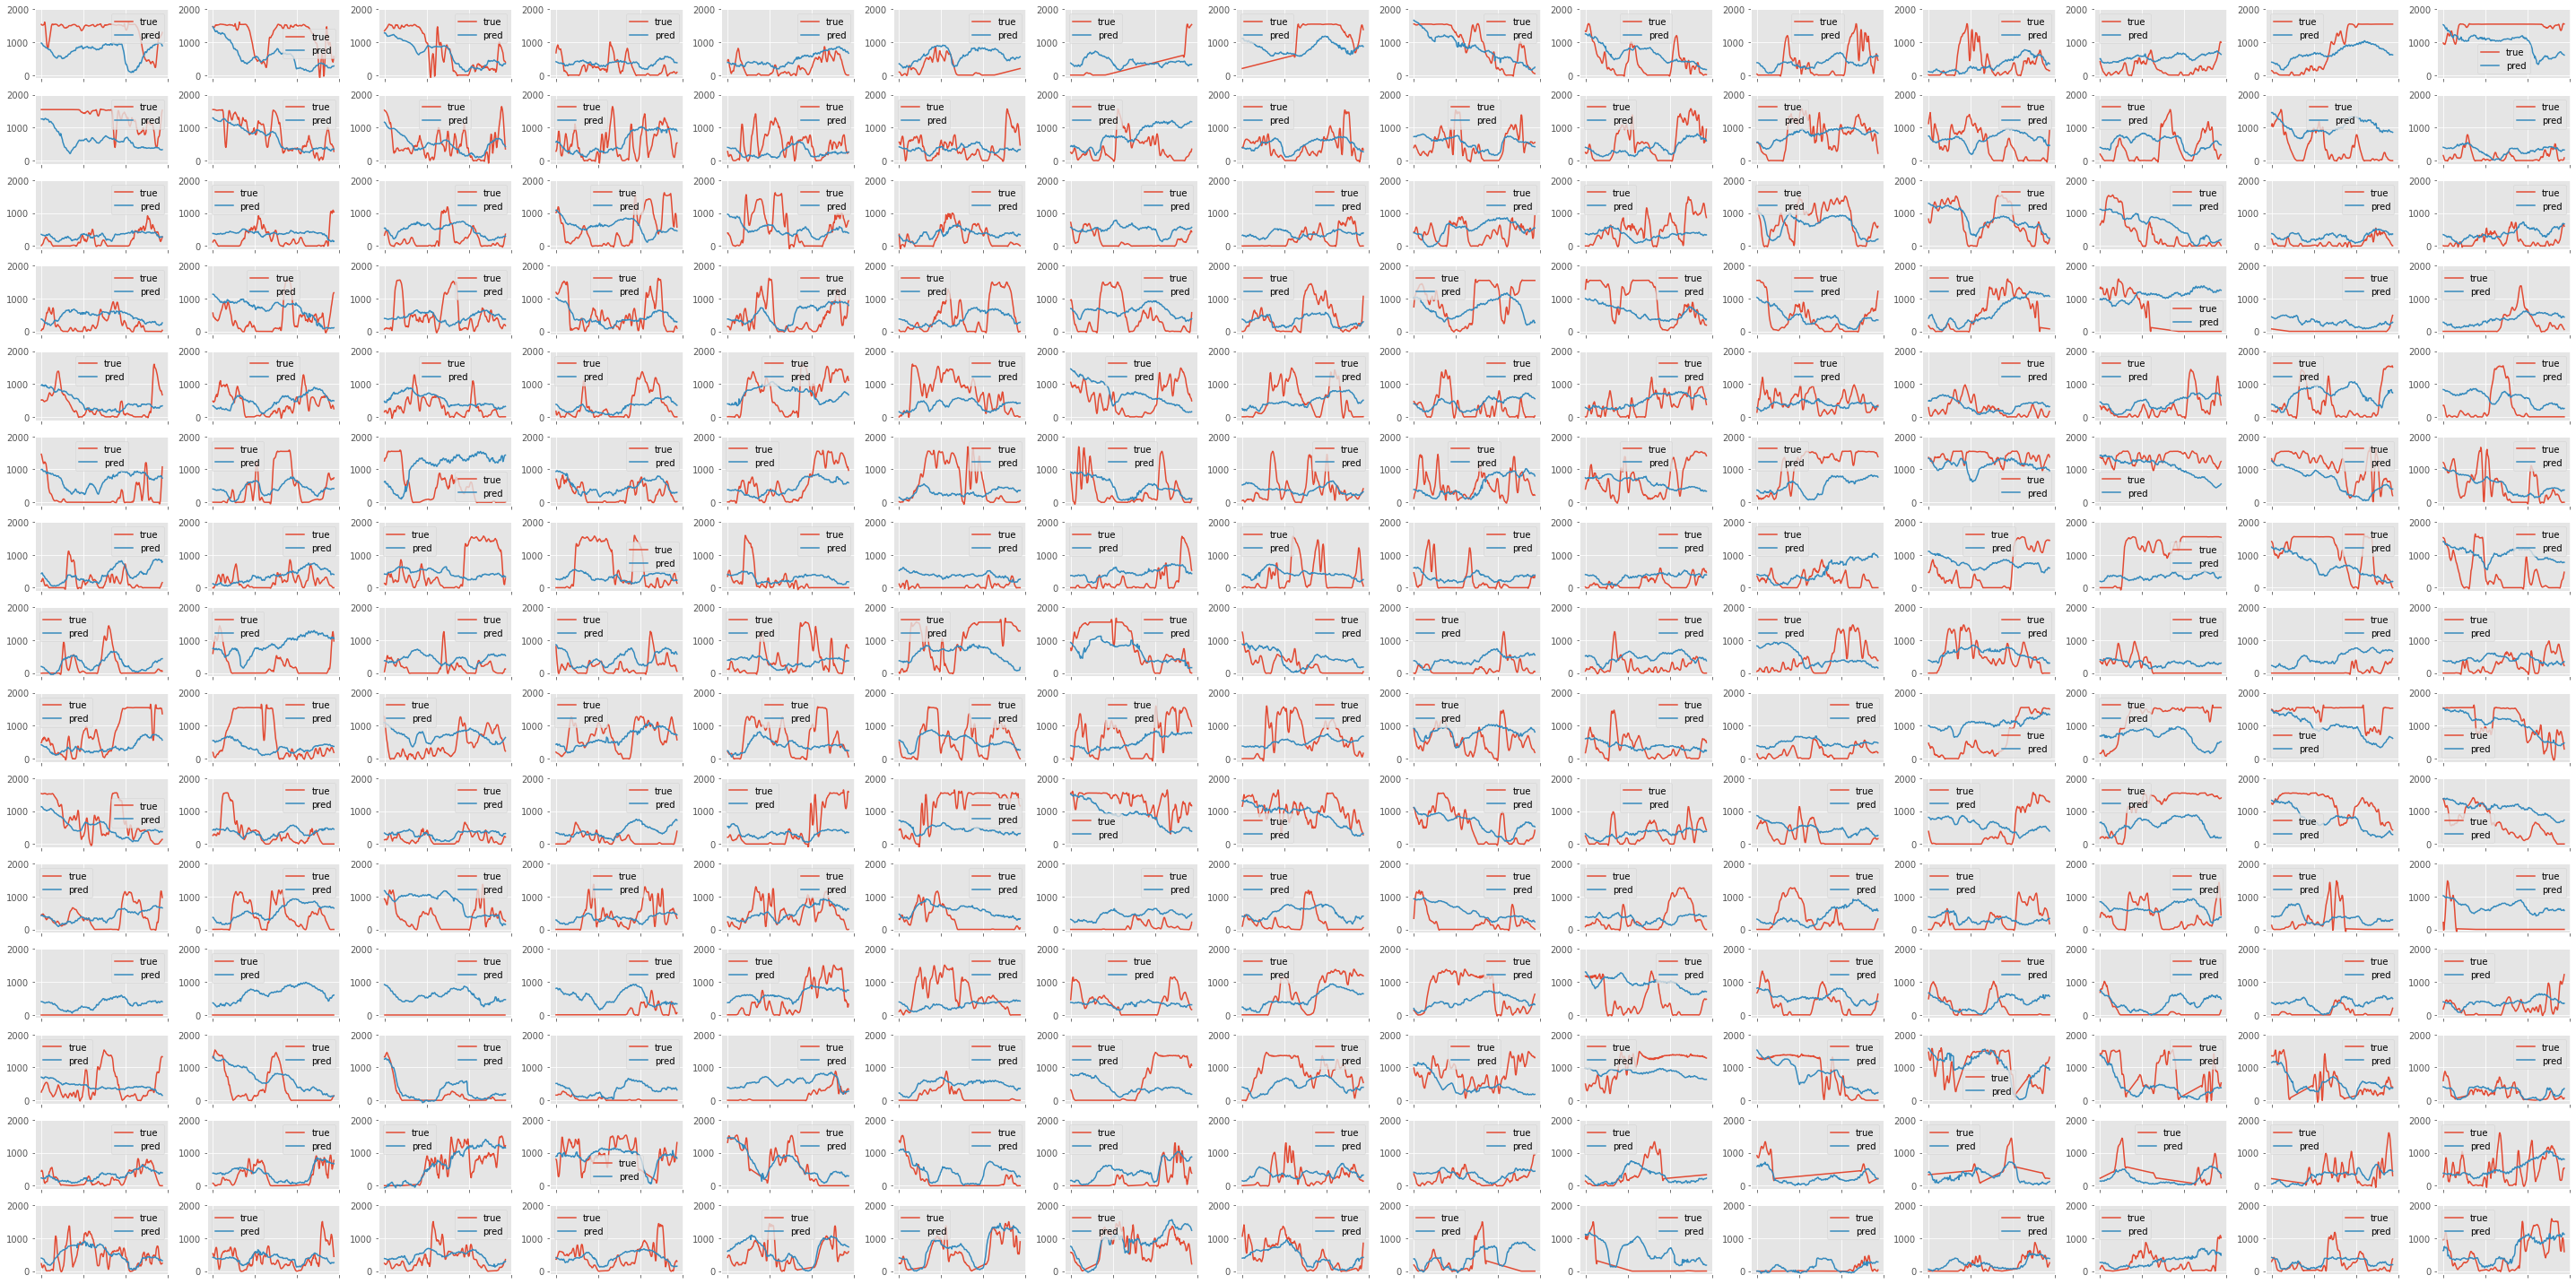

In [43]:
y_true_real = scaler.inverse_transform(y_true.reshape(-1, y_true.shape[-1])).reshape(y_true.shape)[:, :, -1]
y_pred_real = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)[:, :, -1]
visualize_result(y_true_real, y_pred_real, ylim=[-100, 2000])

# 6. Generate submission

In [36]:
X      = np.array(test_x, dtype=np.float32)
y_pred = model.predict(X)

sample_submission['Patv'] = y_pred[:, :, -1].reshape(-1)
sample_submission.to_csv(join(PATH.output, "proposed18.csv"), index=False)

5/5 [==============================] - 0s 32ms/step
